<a href="https://colab.research.google.com/github/castrokelly/eEDB-001-2023-4/blob/main/Cidades_Submersas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cidades Submersas - Brasil

##Oportunidade de Uso de Aprendizagem de Máquina

Este projeto visa analisar o impacto do aumento do nível do mar sobre as cidades brasileiras, utilizando aprendizagem de máquina para prever em qual ano cidades no Brasil podem ficar submersas. A análise utiliza dois conjuntos de dados: um sobre o nível do mar global e outro detalhando informações sobre cidades brasileiras.

A aplicação de aprendizagem de máquina neste contexto permite prever futuros cenários com base em tendências atuais, oferecendo informações cruciais para planejamento urbano, medidas de prevenção e adaptação às mudanças climáticas.

Os dados estão disponibilizados na plataforma Kaggle:

https://www.kaggle.com/datasets/kkhandekar/global-sea-level-1993-2021

https://www.kaggle.com/datasets/crisparada/brazilian-cities/

#Aprendizado de Máquina Supervisionado: Regressão

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#Bibliotecas


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install --upgrade scikit-learn
!pip install --upgrade imbalanced-learn

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from imblearn.over_sampling import SMOTE
from tabulate import tabulate
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')


#Carregamento dos dados

Dados sobre o Nível do Mar Global (`sea_level`): Focaremos no GlobalMeanSeaLevel ao longo dos anos.

In [5]:
sea_level = pd.read_csv('/content/sealevel.csv', encoding='utf-8', sep=',')

Dados das Cidades Brasileiras (`brazil_cities`): Nos concentraremos na altitude das cidades (ALT).

In [6]:
brazil_cities = pd.read_csv('/content/BRAZIL_CITIES_REV2022.CSV', encoding='utf-8', sep=',')

#Análise Estatística Descritiva

In [7]:
sea_level.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048 entries, 0 to 1047
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Year                         1048 non-null   int64  
 1   TotalWeightedObservations    1048 non-null   float64
 2   GMSL_noGIA                   1048 non-null   float64
 3   StdDevGMSL_noGIA             1048 non-null   float64
 4   SmoothedGSML_noGIA           1048 non-null   float64
 5   GMSL_GIA                     1048 non-null   float64
 6   StdDevGMSL_GIA               1048 non-null   float64
 7   SmoothedGSML_GIA             1048 non-null   float64
 8   SmoothedGSML_GIA_sigremoved  1048 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 73.8 KB


In [8]:
brazil_cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5578 entries, 0 to 5577
Data columns (total 81 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CITY                    5578 non-null   object 
 1   STATE                   5578 non-null   object 
 2   CAPITAL                 5578 non-null   int64  
 3   IBGE_RES_POP            5578 non-null   int64  
 4   IBGE_RES_POP_BRAS       5578 non-null   int64  
 5   IBGE_RES_POP_ESTR       5578 non-null   int64  
 6   IBGE_DU                 5578 non-null   int64  
 7   IBGE_DU_URBAN           5578 non-null   int64  
 8   IBGE_DU_RURAL           5578 non-null   int64  
 9   IBGE_POP                5578 non-null   int64  
 10  IBGE_1                  5578 non-null   int64  
 11  IBGE_1-4                5578 non-null   int64  
 12  IBGE_5-9                5578 non-null   int64  
 13  IBGE_10-14              5578 non-null   int64  
 14  IBGE_15-59              5578 non-null   

# Análises Descritivas

**Dados do Nível do Mar**

Período: 1993 - 2021

Média do Nível Médio Global do Mar (GMSL_noGIA): 4.65 mm

Desvio Padrão do GMSL_noGIA: 87.01 mm

Média do GMSL Suavizado (com e sem ajuste de isostasia glacial): Varia entre 4.70 mm e 8.21 mm

In [9]:
sea_level.describe()

,Year,TotalWeightedObservations,GMSL_noGIA,StdDevGMSL_noGIA,SmoothedGSML_noGIA,GMSL_GIA,StdDevGMSL_GIA,SmoothedGSML_GIA,SmoothedGSML_GIA_sigremoved
count,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000
mean,2006.742366,326568.269981,4.645515,87.007700,4.702004,8.112557,87.062805,8.168273,8.213044
std,8.231978,28044.226934,26.351001,5.525201,26.171990,28.310139,5.557840,28.138879,27.976127
min,1993.000000,906.100000,-44.390000,77.410000,-39.780000,-43.140000,77.420000,-39.770000,-39.110000
25%,2000.000000,327418.897500,-18.250000,83.510000,-17.882500,-16.615000,83.617500,-16.087500,-17.440000
50%,2007.000000,331979.205000,1.930000,85.925000,1.505000,5.465000,85.935000,5.065000,5.170000
75%,2014.000000,335243.865000,25.857500,88.602500,26.115000,30.942500,88.732500,31.095000,29.697500
max,2021.000000,341335.090000,57.920000,118.720000,56.310000,64.390000,118.760000,63.070000,60.560000


**Dados das Cidades Brasileiras**

Número de Cidades: 5578

População Média (IBGE_RES_POP): Aproximadamente 34.223 habitantes

Número Médio de Unidades Domiciliares (IBGE_DU): Aproximadamente 10.283

População Total Média (IBGE_POP): Aproximadamente 27.553 habitantes

In [10]:
brazil_cities.describe()

,CAPITAL,IBGE_RES_POP,IBGE_RES_POP_BRAS,IBGE_RES_POP_ESTR,IBGE_DU,IBGE_DU_URBAN,IBGE_DU_RURAL,IBGE_POP,IBGE_1,IBGE_1-4,...,Pu_Bank,Pr_Assets,Pu_Assets,Cars,Motorcycles,Wheeled_tractor,UBER,MAC,WAL-MART,POST_OFFICES
count,5578.000000,5.578000e+03,5.578000e+03,5578.000000,5.578000e+03,5.578000e+03,5578.000000,5.578000e+03,5578.000000,5578.000000,...,5578.000000,5.578000e+03,5.578000e+03,5.578000e+03,5.578000e+03,5578.000000,5578.000000,5578.000000,5578.000000,5578.000000
mean,0.005916,3.422313e+04,3.414573e+04,77.404625,1.028313e+04,8.842319e+03,1440.807458,2.755270e+04,382.669236,1542.089100,...,0.947293,5.500436e+09,3.598663e+09,9.839788e+03,4.869557e+03,5.739871,0.022409,0.127465,0.037827,2.035497
std,0.076695,2.028829e+05,2.012627e+05,1793.789719,6.469199e+04,6.428575e+04,1690.483808,1.857468e+05,2324.175869,9242.622881,...,1.069279,2.775752e+11,1.164327e+11,9.175728e+04,2.091673e+04,55.301718,0.148024,2.151446,0.533446,4.378558
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,5.217000e+03,5.214000e+03,0.000000,1.565250e+03,8.700000e+02,469.250000,2.784250e+03,38.000000,158.000000,...,0.000000,0.000000e+00,0.000000e+00,5.990000e+02,5.880000e+02,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,1.092650e+04,1.091600e+04,0.000000,3.167000e+03,1.839500e+03,916.000000,6.156000e+03,92.000000,376.000000,...,1.000000,0.000000e+00,2.319925e+07,1.431500e+03,1.280000e+03,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,2.340900e+04,2.338000e+04,10.000000,6.722500e+03,4.618750e+03,1811.750000,1.529875e+04,232.000000,949.750000,...,2.000000,4.774853e+07,1.991191e+08,4.084000e+03,3.292750e+03,1.000000,0.000000,0.000000,0.000000,2.000000
max,1.000000,1.125350e+07,1.113378e+07,119727.000000,3.576148e+06,3.548433e+06,33809.000000,1.046364e+07,129464.000000,514794.000000,...,8.000000,1.947077e+13,8.016164e+12,5.740995e+06,1.134570e+06,3236.000000,1.000000,130.000000,26.000000,225.000000


In [11]:
sea_level.sample(10)

,Year,TotalWeightedObservations,GMSL_noGIA,StdDevGMSL_noGIA,SmoothedGSML_noGIA,GMSL_GIA,StdDevGMSL_GIA,SmoothedGSML_GIA,SmoothedGSML_GIA_sigremoved
822,2015,335113.91,27.02,89.37,28.55,32.49,89.43,34.00,37.82
855,2016,335285.81,37.36,96.32,37.09,43.01,96.17,42.75,45.33
484,2006,335596.59,-2.16,87.49,-2.50,1.04,87.27,0.69,2.41
222,1999,327997.69,-26.37,82.39,-26.87,-24.90,82.33,-25.41,-24.73
369,2003,336995.09,-11.69,88.07,-7.51,-9.25,88.09,-5.08,-4.55
854,2016,320305.69,40.67,94.97,38.02,46.31,94.89,43.67,45.95
146,1996,323145.59,-28.35,85.95,-26.17,-27.39,85.93,-25.21,-25.85
583,2008,333620.59,8.61,85.23,8.80,12.48,85.35,12.67,8.91
1031,2021,337427.50,52.70,84.70,51.93,59.50,84.80,58.72,59.20
817,2015,330404.41,29.03,90.09,30.08,34.47,90.12,35.48,37.72


In [12]:
brazil_cities.sample(10)

,CITY,STATE,CAPITAL,IBGE_RES_POP,IBGE_RES_POP_BRAS,IBGE_RES_POP_ESTR,IBGE_DU,IBGE_DU_URBAN,IBGE_DU_RURAL,IBGE_POP,...,Pu_Bank,Pr_Assets,Pu_Assets,Cars,Motorcycles,Wheeled_tractor,UBER,MAC,WAL-MART,POST_OFFICES
3222,Nazária,PI,0,8068,8068,0,2204,456,1748,1640,...,0,0,0,226,596,0,0,0,0,1
66,Alcântara,MA,0,21851,21851,0,6084,1683,4401,6383,...,0,18171127,0,327,1282,0,0,0,0,1
1848,Garanhuns,PE,0,129408,129396,12,37392,33661,3731,111451,...,3,530902982,1862092445,25641,19390,0,1,0,0,4
2048,Ibaretama,CE,0,12922,12922,0,3456,1220,2236,4426,...,0,0,0,715,1859,0,0,0,0,4
1883,Godofredo Viana,MA,0,10635,10635,0,2494,1652,842,6540,...,0,0,0,103,709,0,0,0,0,1
3002,Medicilândia,PA,0,27328,27328,0,7414,2707,4707,9502,...,2,0,74582890,770,4530,0,0,0,0,1
1914,Governador Luiz Rocha,MA,0,7337,7337,0,1898,1362,536,5179,...,0,0,0,179,813,0,0,0,0,1
1000,Canápolis,MG,0,11365,11365,0,3698,3295,403,10029,...,1,0,100236334,2312,1139,0,0,0,0,1
581,Bertolínia,PI,0,5319,5319,0,1462,1098,364,3886,...,0,0,0,248,837,1,0,0,0,1
431,Balneário Barra Do Sul,SC,0,8430,8400,30,2890,2777,113,7830,...,0,0,0,3184,837,5,0,0,0,1


In [13]:
sea_level.shape

(1048, 9)

In [14]:
brazil_cities.shape

(5578, 81)

In [15]:
print("tamanho sea_level:",sea_level.size,"\ntamanho brazil_cities:",brazil_cities.size)

tamanho sea_level: 9432 
tamanho brazil_cities: 451818


Colunas relevantes selecionadas e renomeadas para facilitar as análises:

Year: Ano das observações

MeanSeaLevel: Média do nível do mar

StdDevSeaLevel: Desvio padrão do nível do mar

SmoothedSeaLevel: Nível do mar suavizado

In [16]:
sea_level_df_cleaned = sea_level[["Year", "GMSL_noGIA", "StdDevGMSL_noGIA", "SmoothedGSML_noGIA"]].copy()
sea_level_df_cleaned.columns = ["Year", "MeanSeaLevel", "StdDevSeaLevel", "SmoothedSeaLevel"]


Colunas relevantes selecionadas e renomeadas:

City: Nome da cidade

State: Estado

ResidentPopulation: População residente

ALT: Altitude

In [17]:
brazil_cities_df_cleaned = brazil_cities[["CITY", "STATE", "IBGE_RES_POP", "ALT"]].copy()
brazil_cities_df_cleaned.columns = ["City", "State", "ResidentPopulation", "ALT"]

Visualizando as primeiras linhas dos dataframes com as colunas alteradas:

In [18]:
sea_level_df_cleaned_head = sea_level_df_cleaned.head()
brazil_cities_df_cleaned_head = brazil_cities_df_cleaned.head()

sea_level_df_cleaned_head, brazil_cities_df_cleaned_head

(   Year  MeanSeaLevel  StdDevSeaLevel  SmoothedSeaLevel
 0  1993        -38.59           89.86            -38.76
 1  1993        -41.97           90.86            -39.78
 2  1993        -41.93           87.27            -39.62
 3  1993        -42.67           90.75            -39.67
 4  1993        -37.86           90.26            -38.75,
                   City State  ResidentPopulation        ALT
 0      Abadia De Goiás    GO                6876   893.6015
 1  Abadia Dos Dourados    MG                6704   753.1249
 2            Abadiânia    GO               15757  1017.5506
 3           Abaetetuba    PA              141100    10.1203
 4               Abaeté    MG               22690   644.7399)

Produrando por valores faltantes:

In [19]:
missing_values_sea_level = sea_level.isnull().sum()
missing_values_brazil_cities = brazil_cities.isnull().sum()

missing_values_sea_level, missing_values_brazil_cities

(Year                           0
 TotalWeightedObservations      0
 GMSL_noGIA                     0
 StdDevGMSL_noGIA               0
 SmoothedGSML_noGIA             0
 GMSL_GIA                       0
 StdDevGMSL_GIA                 0
 SmoothedGSML_GIA               0
 SmoothedGSML_GIA_sigremoved    0
 dtype: int64,
 CITY                 0
 STATE                0
 CAPITAL              0
 IBGE_RES_POP         0
 IBGE_RES_POP_BRAS    0
                     ..
 Wheeled_tractor      0
 UBER                 0
 MAC                  0
 WAL-MART             0
 POST_OFFICES         0
 Length: 81, dtype: int64)

#Preparação dos Dados para Modelagem


#Análise da Distribuição dos Dados:

Verificando a distribuição do nível do mar e da altitude das cidades.

#Correlação:

Explorar a correlação entre o ano e o nível médio global do mar.

#Modelo de Regressão Linear para Previsão do Nível do Mar

In [20]:
# Usaremos 'Year' como variável independente e 'GMSL_noGIA' como variável dependente
X = sea_level[['Year']]
y = sea_level['GMSL_noGIA']

In [21]:
# Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [22]:
# Criando o modelo de regressão linear
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [23]:
# Realizando previsões com o modelo
y_pred = model.predict(X_test)

In [24]:
# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


O modelo de regressão linear foi treinado para prever a variação do nível médio global do mar (GMSL_noGIA) com base no ano. Os resultados são os seguintes:


*   Mean Squared Error (MSE): `38.26`
*   Coeficiente de Determinação (R²): `0.94`

**O valor de R² próximo de 1 indica que o modelo é bastante eficaz em capturar a variação do nível do mar ao longo do tempo.**

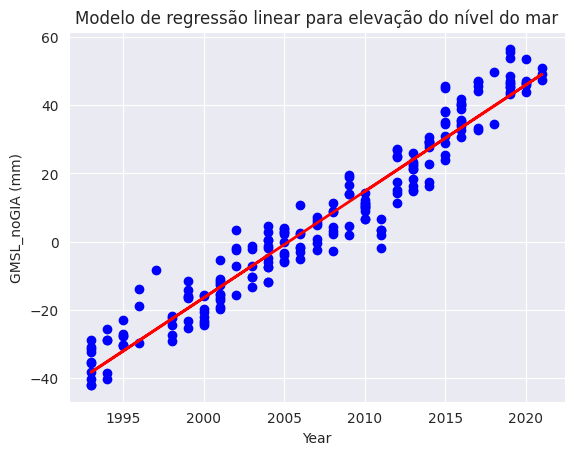

(38.2562272338931, 0.9399584206781438)

In [26]:
# Plotando os resultados
plt.scatter(X_test, y_test, color='blue')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.xlabel('Year')
plt.ylabel('GMSL_noGIA (mm)')
plt.title('Modelo de regressão linear para elevação do nível do mar')
plt.show()

mse, r2

Gráfico do Modelo

O gráfico mostra os dados reais (em azul) e as previsões do modelo (em vermelho). Observa-se uma clara tendência linear, indicando que o modelo conseguiu capturar bem a relação entre o ano e a variação do nível do mar.

#Conclusão e Sugestões para Continuação do Estudo

Este modelo fornece uma estimativa inicial para entender como o nível do mar pode variar com o tempo. No entanto, é importante considerar que a realidade é mais complexa. Fatores como mudanças climáticas, atividades humanas e variações geográficas específicas também influenciam o nível do mar.


Possíveis Continuações do Estudo:

**Incorporar mais variáveis:** Incluir outras variáveis relevantes, como emissões de CO2, temperatura global e atividades geológicas.

**Modelos mais complexos:** Explorar modelos de aprendizado de máquina mais sofisticados que possam capturar relações não lineares e interações entre diferentes variáveis.

**Dados mais detalhados:** Obter dados mais granulares, como medições de nível do mar em locais específicos, e correlacioná-los com altitudes das cidades brasileiras.